In [5]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import math
import csv
import math
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors

Cuts

In [ ]:
def truth_cuts(pdg, p, mode):
    nprotons = np.count_nonzero(pdg == 2212)
    nmuons = np.count_nonzero(pdg == 13) + np.count_nonzero(pdg == -13)
    npions = np.count_nonzero(pdg == 111) + np.count_nonzero(pdg == 211) + np.count_nonzero(pdg == -211) 

    #CC1mu2p
    if nprotons == 2 and nmuons == 1 and npions == 0: #and mode == 10: #2p2h
        return 1
    else:
        return 0
    
def reco_cuts(pdg, p, x_end, y_end, z_end):
    #Add cut to require entire proton track is contained
    nprotons = 0
    nmuons = 0
    npions = 0

    for part in range(len(pdg)):
        if pdg[part] == 2212 and p[part] <= 1.0 and p[part] > 0.2:
            if is_contained(x_end[part], y_end[part], z_end[part]):
                nprotons += 1
        if pdg[part] == 13 or pdg[part] == -13:
            if p[part] >= 0.15:
                nmuons += 1
        if pdg[part] == 111 or pdg[part] == 211 or pdg[part] == -211:
            npions += 1

    if nprotons == 2 and nmuons == 1 and npions == 0:
        return 1
    else:
        return 0
    
def mag(x):
    return np.sqrt(np.sum(i ** 2 for i in x))

def is_contained(x, y, z):
    tpc_dist = 8.0 #distance from the tpc walls for containment cuts
    xbound = 63.931
    ybound = 62.076
    zbound = 64.3163

    cont = False

    if abs(x) < xbound - tpc_dist and abs(y) < ybound - tpc_dist and abs(z) < zbound - tpc_dist:
        cont = True

    return cont

Purity file

File contains events that have passed the reconstruction cuts, and were identified as potential signal events

In [7]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/purity_efficiency/2p2h_purity_eff_output_1.5.root")
tracks["CafTree"].show()
tracks["CafTree"].keys()

branches = tracks["CafTree"].arrays()[0]
file_index = branches['file_index']
print(np.unique(file_index))

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

Calculate Purity <br>
Purity = Number of True CC1mu2p0pi Events that pass all cuts/Number of events that pass all cuts <br>
Calculate Efficiency <br>
Efficiency = Number of true signal events that pass all cuts/Number of true signal events <br> <br>

Signal means the reconstructed event is the "signal" we are looking for (reco passes the cuts) <br>
True means the truth level event is what we are looking for (truth passes the cuts)

In [ ]:
#Arrays to save information on whether each event passes reco and true cuts
true_signal_event = []
true_event = []
signal_event = []

#Reco momentum and proton angle information
leading_p_p = []
recoil_p_p = []
muon_p = []
theta_pp = []

#Reco and true proton momentum and neutrino energy
true_proton_p = []
reco_proton_p = []
true_nu_momentum = []

#Proton ID accuracy
true_proton_id = []
reco_proton_id = []
acc_proton_p = []

#Proton true and reco momentum for 2D histogram
hist_proton_truep = []
hist_proton_recop = []

#Loop through each file index
for file_idx in np.unique(file_index):
    true_energy = branches['true_energy'][file_index == file_idx]
    true_p_x = branches['true_p_x'][file_index == file_idx]
    true_p_y = branches['true_p_y'][file_index == file_idx]
    true_p_z = branches['true_p_z'][file_index == file_idx]
    true_p_mag = branches['true_p_mag'][file_index == file_idx]
    true_length = branches['true_length'][file_index == file_idx]
    true_angle = branches['true_angle'][file_index == file_idx]
    true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
    true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
    true_angle_x = branches['true_angle_x'][file_index == file_idx]
    true_angle_y = branches['true_angle_y'][file_index == file_idx]
    true_angle_z = branches['true_angle_z'][file_index == file_idx]
    true_vtx_x = branches['true_vtx_x'][file_index == file_idx]
    true_vtx_y = branches['true_vtx_y'][file_index == file_idx]
    true_vtx_z = branches['true_vtx_z'][file_index == file_idx]
    true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
    true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
    true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
    true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
    true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
    true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
    true_pdg = branches['true_pdg'][file_index == file_idx]
    true_nproton = branches['true_nproton'][file_index == file_idx]
    mode = branches['mode'][file_index == file_idx]
    nu_momentum_x = branches['nu_momentum_x'][file_index == file_idx]
    nu_momentum_y = branches['nu_momentum_y'][file_index == file_idx]
    nu_momentum_z = branches['nu_momentum_z'][file_index == file_idx]

    reco_energy = branches['reco_energy'][file_index == file_idx]
    reco_p_x = branches['reco_p_x'][file_index == file_idx]
    reco_p_y = branches['reco_p_y'][file_index == file_idx]
    reco_p_z = branches['reco_p_z'][file_index == file_idx]
    reco_p_mag = branches['reco_p_mag'][file_index == file_idx]
    reco_length = branches['reco_length'][file_index == file_idx]
    reco_angle = branches['reco_angle'][file_index == file_idx]
    reco_angle_rot = branches['reco_angle_rot'][file_index == file_idx]
    reco_angle_incl = branches['reco_angle_incl'][file_index == file_idx]
    reco_angle_x = branches['reco_angle_x'][file_index == file_idx]
    reco_angle_y = branches['reco_angle_y'][file_index == file_idx]
    reco_angly_z = branches['reco_angle_z'][file_index == file_idx]
    reco_vtx_x = branches['reco_vtx_x'][file_index == file_idx]
    reco_vtx_y = branches['reco_vtx_y'][file_index == file_idx]
    reco_vtx_z = branches['reco_vtx_z'][file_index == file_idx]
    reco_track_start_x = branches['reco_track_start_x'][file_index == file_idx]
    reco_track_start_y = branches['reco_track_start_y'][file_index == file_idx]
    reco_track_start_z = branches['reco_track_start_z'][file_index == file_idx]
    reco_track_end_x = branches['reco_track_end_x'][file_index == file_idx]
    reco_track_end_y = branches['reco_track_end_y'][file_index == file_idx]
    reco_track_end_z = branches['reco_track_end_z'][file_index == file_idx]
    reco_pdg = branches['reco_pdg'][file_index == file_idx]
    reco_enu_calo = branches['reco_enu_calo'][file_index == file_idx]

    reco_ixn_index = branches['reco_ixn_index'][file_index == file_idx]
    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in np.unique(event):

        reco_pdg_ev = reco_pdg[event == ev]
        true_pdg_ev = true_pdg[event == ev]

        #Do the reco event and matching truth event pass the cuts?
        reco_passes = reco_cuts(reco_pdg[event == ev], reco_p_mag[event == ev], reco_track_end_x[event == ev], reco_track_end_y[event == ev], reco_track_end_z[event == ev])
        truth_passes = truth_cuts(true_pdg[event == ev], true_p_mag[event == ev], mode[event == ev][0])

        signal_event.append(reco_passes)
        true_event.append(truth_passes)

        if reco_passes == 1 and truth_passes == 1:
            true_signal_event.append(1)
        else:
            true_signal_event.append(0)

        #Save proton and muon momentum information for plots
        proton_p_reco = reco_p_mag[event == ev][reco_pdg[event == ev] == 2212]
        proton_p_truth = true_p_mag[event == ev][true_pdg[event == ev] == 2212]
        muon_p_reco = reco_p_mag[event == ev][reco_pdg[event == ev] == 13]
        
        #Loop through particles
        #Save info on if proton was identified correctly
        for part in range(len(reco_pdg[event == ev])):
            if true_pdg_ev[part] == 2212:
                true_proton_id.append(True)
                acc_proton_p.append(true_p_mag[event == ev][part])

                if reco_pdg_ev[part] == 2212:
                    reco_proton_id.append(True)

                    #Save proton momentum info for momentum 2d histogram only if the particle is both true and reco proton
                    hist_proton_truep.append(true_p_mag[event == ev][part])
                    hist_proton_recop.append(reco_p_mag[event == ev][part])

                else:
                    reco_proton_id.append(False)

        
        nu_momentum = mag((nu_momentum_x[event == ev][0], nu_momentum_y[event == ev][0], nu_momentum_z[event == ev][0]))

        reco_proton_p.extend(proton_p_reco)
        true_proton_p.extend(proton_p_truth)

        #Find max (lead) and min (recoil) protons
        #Some events may be true CC2p1mu0pi, but the reconstruction may not see any protons
        #We need to account for these events that have no proton momentum
        if len(proton_p_reco) == 0:
            leading_p_p.append(0)
            recoil_p_p.append(0)
        else:
            leading_p_p.append(max(proton_p_reco))
            recoil_p_p.append(min(proton_p_reco))

        if len(muon_p_reco) == 0:
            muon_p.append(0)
        else:
            muon_p.append(max(muon_p_reco))

        true_nu_momentum.append(nu_momentum)
        
        #Save angle between protons for plots FOR LATER

#In this code, signal means event that passes the reco cuts (detector would identify it as a 2p2h event)
#True signal event means an event that passes the reco cuts and is a 2p2h event at truth level
#True event is a 2p2h event at truth level
num_true_signal = sum(true_signal_event) #Number of 2p2h events that pass the cut
num_background = sum(signal_event) - num_true_signal #Number of background events that pass the cut

print("Number of signal events", num_true_signal)

print("Number of background events", num_background)

purity = sum(true_signal_event)/sum(signal_event)
print("Purity measurement: ", purity)

efficiency = sum(true_signal_event)/sum(true_event)
print("Efficiency measurement: ", efficiency)

/tmp/ipykernel_2771338/3659196380.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i ** 2 for i in x))


Number of signal events 154
Number of background events 159
Purity measurement:  0.49201277955271566
Efficiency measurement:  0.6062992125984252


Purity and efficiency plots

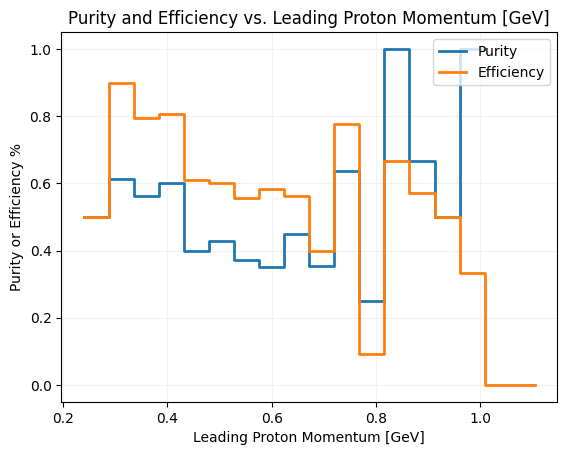

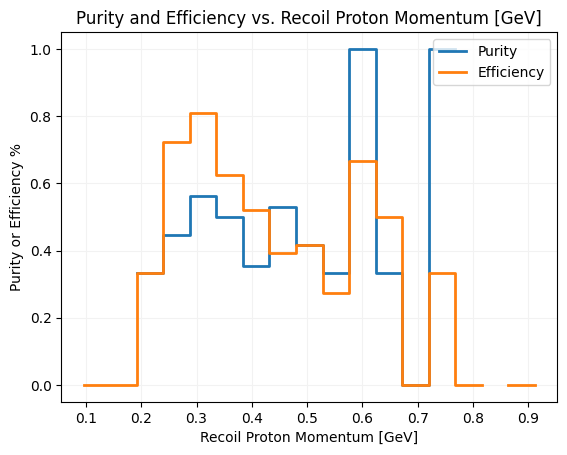

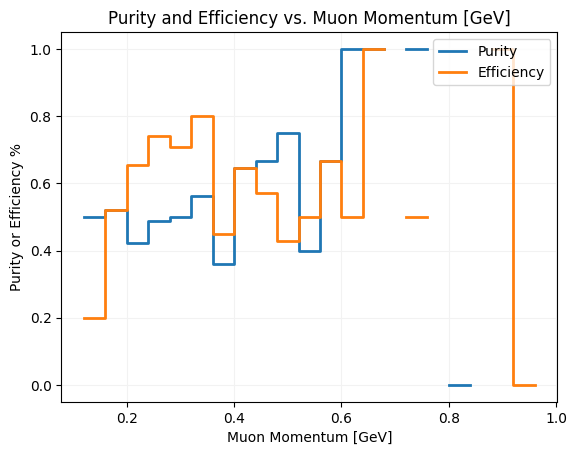

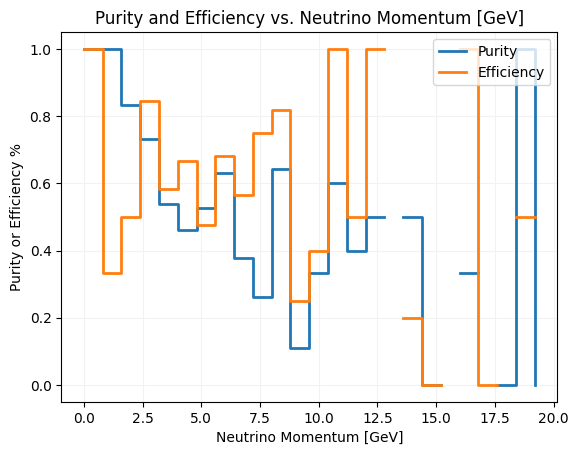

     signal  true  true and signal  leading proton p  recoil proton p  \
0         0     0                0          0.459065         0.114610   
1         0     1                0          0.593397         0.457576   
2         0     0                0          0.682856         0.222758   
3         0     0                0          0.682304         0.361678   
4         0     0                0          0.858352         0.782534   
..      ...   ...              ...               ...              ...   
615       1     0                0          0.495677         0.338615   
616       1     0                0          0.455176         0.407003   
617       0     1                0          0.356980         0.339610   
618       0     0                0          0.262027         0.194671   
619       1     0                0          0.541699         0.290540   

         muon p  nu momentum bin lpp bin rpp bin mu bin nu  
0      0.219460     6.991093       9       2      5      8  
1

In [9]:
data = {'signal': signal_event, 'true': true_event, 'true and signal': true_signal_event, 'leading proton p': leading_p_p, 'recoil proton p': recoil_p_p, 'muon p': muon_p, 'nu momentum': true_nu_momentum}
df = pd.DataFrame(data=data)

purity_vals_lpp = []
purity_vals_rpp = []
purity_vals_mu = []
purity_vals_nu = []
eff_vals_lpp = []
eff_vals_rpp = []
eff_vals_mu = []
eff_vals_nu = []

#Leading proton momentum binning
nbins_lpp = 25
hist_lpp, bin_edges_lpp = np.histogram(leading_p_p, bins=nbins_lpp, range=(0,1.2)) #Create bins based on leading proton momentum
labels_lpp = np.arange(0, nbins_lpp) #Label each bin numerically for leading proton momentum

df['bin lpp'] = pd.cut(df['leading proton p'], bins=bin_edges_lpp, labels=labels_lpp) #Create a column in df defining the number bin each event is in based on leading proton momentum

#Recoil proton momentum binning
nbins_rpp = 25
hist_rpp, bin_edges_rpp = np.histogram(recoil_p_p, bins=nbins_rpp, range=(0,1.2)) #Create bins based on recoil proton momentum
labels_rpp = np.arange(0, nbins_rpp) #Label each bin numerically for recoil proton momentum

df['bin rpp'] = pd.cut(df['recoil proton p'], bins=bin_edges_rpp, labels=labels_rpp) #Create a column in df defining the number bin each event is in based on recoil proton momentum

#Muon momentum binning
nbins_mu = 25
hist_mu, bin_edges_mu = np.histogram(muon_p, bins=nbins_mu, range=(0,1.0)) #Create bins based on recoil proton momentum
labels_mu = np.arange(0, nbins_mu) #Label each bin numerically for recoil proton momentum

df['bin mu'] = pd.cut(df['muon p'], bins=bin_edges_mu, labels=labels_mu) #Create a column in df defining the number bin each event is in based on recoil proton momentum

#Neutrino energy binning
nbins_nu = 25
hist_nu, bin_edges_nu = np.histogram(true_nu_momentum, bins=nbins_nu, range=(0,20)) #Create bins based on true neutrino energy
labels_nu = np.arange(0, nbins_nu) #Label each bin numerically for true neutrino energy

df['bin nu'] = pd.cut(df['nu momentum'], bins=bin_edges_nu, labels=labels_nu) #Create a column in df defining the number bin each event is in based on true neutrino energy



#Loop through each leading proton momentum bin and calculate purity & efficiency
for i in labels_lpp:
    df_bin = df[(df['bin lpp'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_lpp.append(np.nan)
    else:
        purity_vals_lpp.append(sum(true_signal_bin)/sum(signal_bin))
    
    if sum(true_bin) == 0:
        eff_vals_lpp.append(np.nan)
    else:
        eff_vals_lpp.append(sum(true_signal_bin)/sum(true_bin))

#Loop through each recoil proton momentum bin and calculate purity & efficiency
for i in labels_rpp:
    df_bin = df[(df['bin rpp'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_rpp.append(np.nan)
    else:
        purity_vals_rpp.append(sum(true_signal_bin)/sum(signal_bin))

    if sum(true_bin) == 0:
        eff_vals_rpp.append(np.nan)
    else:
        eff_vals_rpp.append(sum(true_signal_bin)/sum(true_bin))

#Loop through each muon momentum bin and calculate purity and efficiency
for i in labels_mu:
    df_bin = df[(df['bin mu'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_mu.append(np.nan)
    else:
        purity_vals_mu.append(sum(true_signal_bin)/sum(signal_bin))

    if sum(true_bin) == 0:
        eff_vals_mu.append(np.nan)
    else:
        eff_vals_mu.append(sum(true_signal_bin)/sum(true_bin))

#Loop through each true neutrino energy bin and calculate purity and efficiency
for i in labels_nu:
    df_bin = df[(df['bin nu'] == i)]

    signal_bin = np.array(df_bin['signal'])
    true_signal_bin = np.array(df_bin['true and signal'])
    true_bin = np.array(df_bin['true'])

    if sum(signal_bin) == 0:
        purity_vals_nu.append(np.nan)
    else:
        purity_vals_nu.append(sum(true_signal_bin)/sum(signal_bin))

    if sum(true_bin) == 0:
        eff_vals_nu.append(np.nan)
    else:
        eff_vals_nu.append(sum(true_signal_bin)/sum(true_bin))


#Plot purity and efficiency vs. leading proton momentum
#Delete the last bin value because we are plotting each step from the leftmost bin edge
plt.step(np.delete(bin_edges_lpp, nbins_lpp), purity_vals_lpp, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_lpp, nbins_lpp), eff_vals_lpp, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Leading Proton Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Leading Proton Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

#Plot purity and efficiency vs. recoil proton momentum
plt.step(np.delete(bin_edges_rpp, nbins_rpp), purity_vals_rpp, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_rpp, nbins_rpp), eff_vals_rpp, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Recoil Proton Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Recoil Proton Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

#Plot purity and efficiency vs. muon momentum
plt.step(np.delete(bin_edges_mu, nbins_mu), purity_vals_mu, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_mu, nbins_mu), eff_vals_mu, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Muon Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Muon Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

#Plot purity and efficiency vs. neutrino energy
plt.step(np.delete(bin_edges_nu, nbins_nu), purity_vals_nu, where='post', label='Purity', linewidth='2')
plt.step(np.delete(bin_edges_nu, nbins_nu), eff_vals_nu, where='post', label='Efficiency', linewidth='2')
plt.xlabel('Neutrino Momentum [GeV]')
plt.ylabel('Purity or Efficiency %')
plt.title('Purity and Efficiency vs. Neutrino Momentum [GeV]')
plt.grid(color='0.95')
plt.legend(loc='upper right')
plt.show()

print(df)

#---------------------------------------------
#Use true and reco energy bins for purity and efficiency
#---------------------------------------------

Proton truth and reco momentum plots

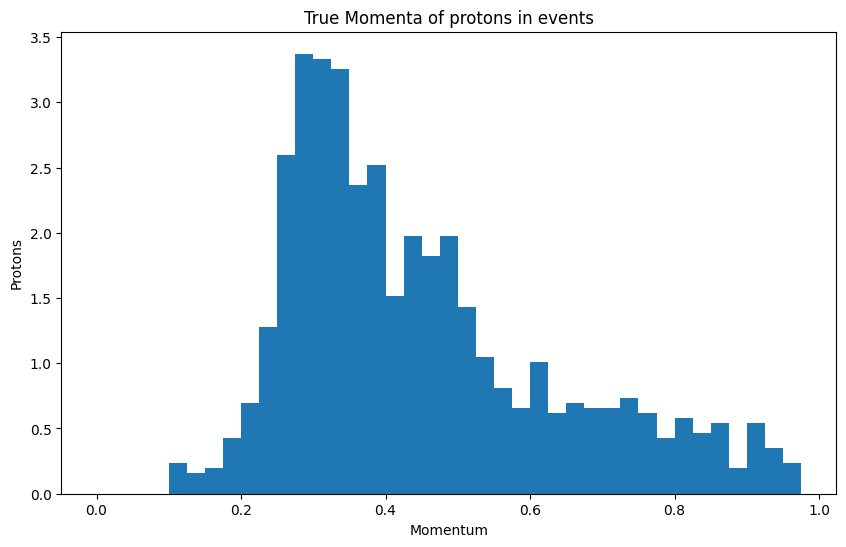

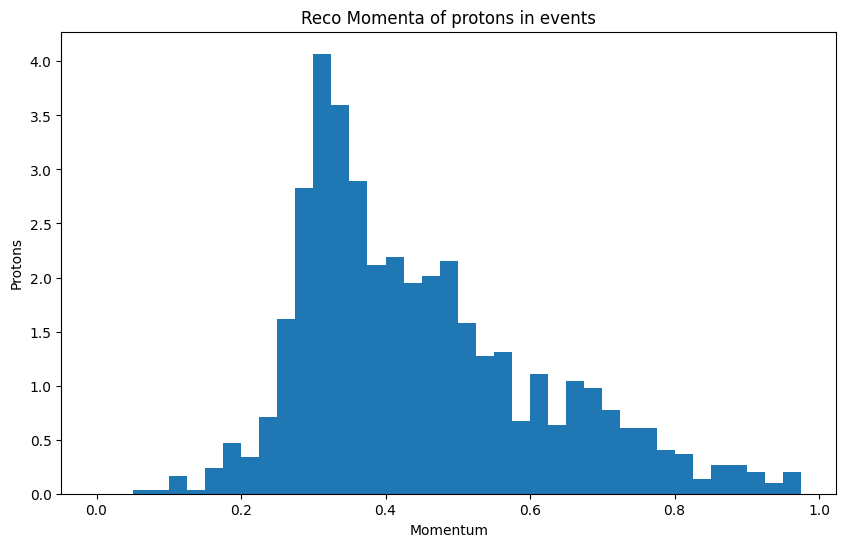

Text(0.5, 1.0, 'Reco vs. True Momentum for Protons in 2p2h Candidate Events in Minirun6')

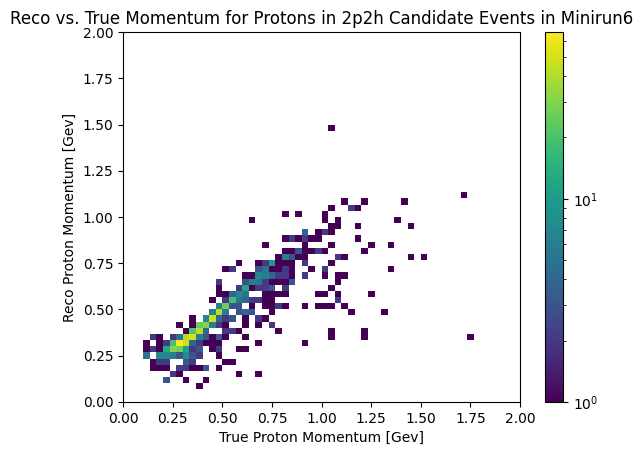

In [10]:
#Split into lead and recoil?

fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(true_proton_p, bins=np.arange(0.0, 1.0, 0.025), density=True)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Momentum")
plt.ylabel("Protons")
plt.title("True Momenta of protons in events")
plt.show()

fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(reco_proton_p, bins=np.arange(0.0, 1.0, 0.025), density=True)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Momentum")
plt.ylabel("Protons")
plt.title("Reco Momenta of protons in events")
plt.show()

#2d histogram
plt.hist2d(hist_proton_truep, hist_proton_recop, bins=60, range=((0,2),(0,2)),norm=colors.LogNorm())
plt.xlabel("True Proton Momentum [Gev]")
plt.ylabel("Reco Proton Momentum [Gev]")
plt.colorbar()
plt.title("Reco vs. True Momentum for Protons in 2p2h Candidate Events in Minirun6")

Accuracy of proton ID by momenta

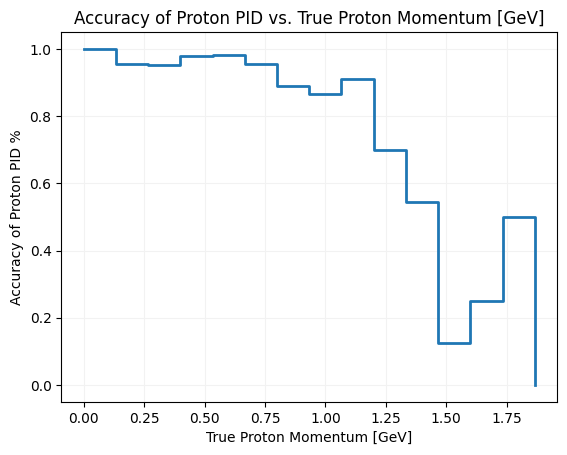

In [11]:
#true_proton_id and reco_proton_id True or False

data_p = {'true_proton_id': true_proton_id, 'reco_proton_id': reco_proton_id, 'acc_proton_p': acc_proton_p}
dfp = pd.DataFrame(data = data_p)

accuracy = []

#Bin by true proton momentum
nbins_acc = 15
hist_acc, bin_edges_acc = np.histogram(acc_proton_p, bins=nbins_acc, range=(0, 2.0)) #Create bins based on true proton momentum
labels_acc = np.arange(0, nbins_acc) #Label each bin numerically for true proton momentum

dfp['bin acc'] = pd.cut(dfp['acc_proton_p'], bins=bin_edges_acc, labels=labels_acc) #Create a column in dfp defining the number bin each event is in based on true proton momentum

#Loop through each true proton momentum bin and calculate accuracy of pid
for i in labels_acc:
    df_bin = dfp[(dfp['bin acc'] == i)]

    acc_bin = []

    true_pid_bin = np.array(df_bin['true_proton_id'])
    reco_pid_bin = np.array(df_bin['reco_proton_id'])

    for j in range(len(true_pid_bin)):
        if true_pid_bin[j] == True and reco_pid_bin[j] == True:
            acc_bin.append(1)
        if true_pid_bin[j] == True and reco_pid_bin[j] == False:
            acc_bin.append(0)

    if len(acc_bin) != 0:
        accuracy.append(sum(acc_bin)/len(acc_bin))

#Plot accuracy of proton pid vs. true proton momentum
plt.step(np.delete(bin_edges_acc, nbins_acc), accuracy, where='post', label='Accuracy', linewidth='2')
plt.xlabel('True Proton Momentum [GeV]')
plt.ylabel('Accuracy of Proton PID %')
plt.title('Accuracy of Proton PID vs. True Proton Momentum [GeV]')
plt.grid(color='0.95')
#plt.legend(loc='upper right')
plt.show()